# K-means and Gaussian Mixture Models: Examples of the EM Algorithm #
    - Matt Robinson

# K-means Clustering

I will implement the batch-version of the algorithm below.

Most of the details are adapted from Bishop (2006).

In k-means clustering, we are trying to minimize an obejective function, or *distortion measure*, $J$:

$$
J = \sum _ { n = 1 } ^ { N } \sum _ { k = 1 } ^ { K } r _ { n k } \left\| \mathbf { x } _ { n } - \boldsymbol { \mu } _ { k } \right\| ^ { 2 }
$$

where $N$ is the number of data points and $K$ is the chosen number of clusters. $r _ { n k } \in \{ 0,1 \}$ is a binary indicator variable that tells us which of the clusters $1,...,K$ the data point $\mathbf{x}_n$ has been assigned to. Finally, $\mathbf{\mu}_k$ is the "cluster center" or prototype vector associated with cluster $k$.

We wish to find the $r _ { n k }$ and $\mathbf{\mu}_k$ that minimize $J$. To accomplish this, we use a two step process.

**Step 0.** Pick the number of clusters $K$ and choose initial values for the $\mathbf{\mu}_k$

**Repeat Until Converged:** 

$\quad$ **(Expectation)** Minimize $J$ with respect to the $r_{nk}$, while keeping the $\mathbf{\mu}_k$ fixed.

$\quad$ **(Maximization)** Minimize $J$ with respect to the $\mathbf{\mu}_k$, while keeping the $r_{nk}$ fixed.

More formally, we can write the mathematical steps needed to perform each step:

$$
\begin{align*}
\quad \text{(Expectation)} \quad r _ { n k } &= \left\{ \begin{array} { l l } { 1 } & { \text { if } k = \arg \min _ { j } \left\| \mathbf { x } _ { n } - \boldsymbol { \mu } _ { j } \right\| ^ { 2 } } \\ { 0 } & { \text { otherwise. } } \end{array} \right. \\
\quad \text{(Maximization)} \quad \boldsymbol { \mu } _ { k } &= \frac { \sum _ { n } r _ { n k } \mathbf { x } _ { n } } { \sum _ { n } r _ { n k } }
\end{align*}
$$

For the expectation step, $r_{nk}$ acts to assign each data point $\mathbf{x}_n$ to the cluster center that is closest to $\mathbf{x}_n$ in terms of Euclidean distance.

For the maximization step, one can see that the denominator $ { \sum _ { n } r _ { n k } }$ is just the number of points assigned to cluster $k$. Thus, $\mathbf{\mu}_k$ is just the mean of all of the data points assigned to cluster $k$. That's why it is called *k-means* clustering. 

Note that we are guarenteed convergence since each step necessarily decreases the distortion measure $J$. However, we are not guarenteed that the algoirthm convergest to a global minimum. Thus, it is often recommended that one runs the algorithm a couple of times to see if the results differ much between runs.

Let's now try to implement the algorithm:

In [1]:
# standard imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns  # for plot styling
import numpy as np
import pandas as pd

In [93]:
class KMeans(object):

    def __init__(self, n_clusters=2, n_init=10, max_iter=300,
                    tol=0.0001, random_state=1):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
    def fit(self, X):
        
        n_samples, n_features = X.shape
        self.cluster_centers_ = np.empty((self.n_clusters, n_features), dtype=X.dtype)
        self.labels_ = np.empty((n_samples), dtype=X.dtype)
        self.inertia_ = 0
        
        # run the k-means algorithm n_init times and pick one with best inertia
        min_inertia = None
        for i in range(self.n_init):
        
            # Randomly choose existing data points as cluster centers
            rng = np.random.RandomState(self.random_state+i)
            starting_center_idxs = rng.permutation(X.shape[0])[:self.n_clusters]

            cluster_centers = X[starting_center_idxs]
            old_cluster_centers = cluster_centers
            labels = np.empty((n_samples), dtype=X.dtype)

            for _ in range(self.max_iter):
                inertia = 0

                # Assign label based on closest cluster center
                for idx, sample in enumerate(X):

                    distances_to_cluster_centers = [np.linalg.norm(sample - cluster_center) 
                                       for cluster_center in cluster_centers]

                    labels[idx] = np.argmin(distances_to_cluster_centers)
                    inertia += np.min(distances_to_cluster_centers)


                # Find new centers from mean of points assigned to cluster
                cluster_centers = np.array([X[labels == i].mean(axis=0)
                                            for i in range(self.n_clusters)]
                                          )

                # Check if converged
                if (np.linalg.norm(cluster_centers-old_cluster_centers))**2 < self.tol:
                    break
                else:
                    old_cluster_centers = cluster_centers
                    
            if (min_inertia is None) or (inertia < min_inertia):   

                min_inertia = inertia
                
                # update class variables if is best cluster
                self.cluster_centers_ = cluster_centers
                self.labels_ = labels
                self.inertia_ = inertia
        
        return self
    
    def predict(self, X):
        
        predicted_labels = np.empty((X.shape[0]), dtype=X.dtype)
        # Assign label based on closest cluster center
        for idx, sample in enumerate(X):
            predicted_labels[idx] = np.argmin(
                    [np.linalg.norm(sample - cluster_center) 
                     for cluster_center in self.cluster_centers_]
                )
        
        return predicted_labels
        

In [94]:
# get the Iris dataset from seaborn
df = sns.load_dataset("iris")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [95]:
from sklearn.model_selection import train_test_split

X, y = df.iloc[:, 0:4].values, df.iloc[:, 4].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

In [96]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [97]:
# train on only two features
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_std[:,0:2])
y_kmeans = kmeans.labels_

/Users/matthewrobinson/anaconda/envs/mlbook/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice.
/Users/matthewrobinson/anaconda/envs/mlbook/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Text(0,0.5,'Sepal Width')

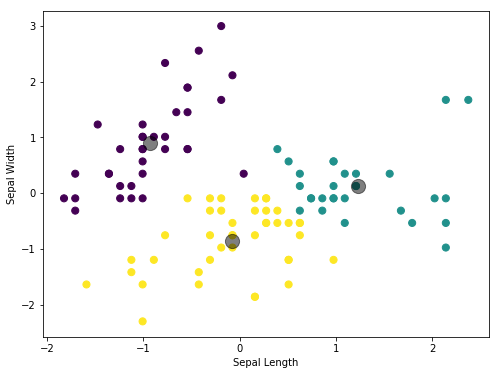

In [98]:
plt.figure(figsize=(8,6))

plt.scatter(X_train_std[:, 0], X_train_std[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")

In [99]:
from matplotlib.colors import ListedColormap

def plot_decision_regions_cluster(X, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:3])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
#     for idx, cl in enumerate(np.unique(y)):
#         plt.scatter(x=X[y == cl, 0], 
#                     y=X[y == cl, 1],
#                     alpha=0.8, 
#                     c=colors[idx],
#                     marker=markers[idx], 
#                     label=cl, 
#                     edgecolor='black')

Text(0,0.5,'Sepal Width')

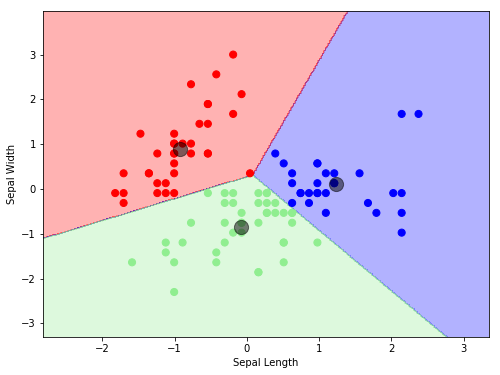

In [100]:
plt.figure(figsize=(8,6))

plot_decision_regions_cluster(X_train_std[:,0:2], classifier=kmeans)

colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
plt.scatter(X_train_std[:, 0], X_train_std[:, 1], c=y_kmeans, s=50, cmap=ListedColormap(colors[:3]))

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")

Of course this required that we knew the appropriate number of clusters in advanced. Let's see if we can find a systematic way to decide on the appropriate number of clusters.

In [84]:
def kmeans_scree_plot(X, k_range=list(range(1,10))):
    
    inertia_list = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        inertia_list.append(kmeans.inertia_)
        
    plt.plot(k_range,inertia_list,
             marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.xlabel("K")
    plt.ylabel("Inertia")

/Users/matthewrobinson/anaconda/envs/mlbook/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice.
/Users/matthewrobinson/anaconda/envs/mlbook/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/matthewrobinson/anaconda/envs/mlbook/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


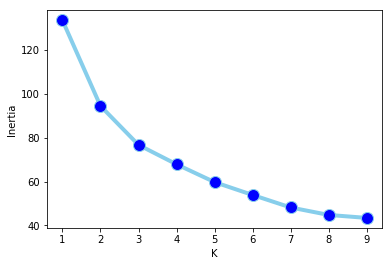

In [85]:
kmeans_scree_plot(X_train_std[:, 0:2], )

Code below is modified from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.6810461692117465
For n_clusters = 3 The average silhouette_score is : 0.5528190123564102
For n_clusters = 4 The average silhouette_score is : 0.49805050499728815
For n_clusters = 5 The average silhouette_score is : 0.4930804067193529
For n_clusters = 6 The average silhouette_score is : 0.3664804028900843


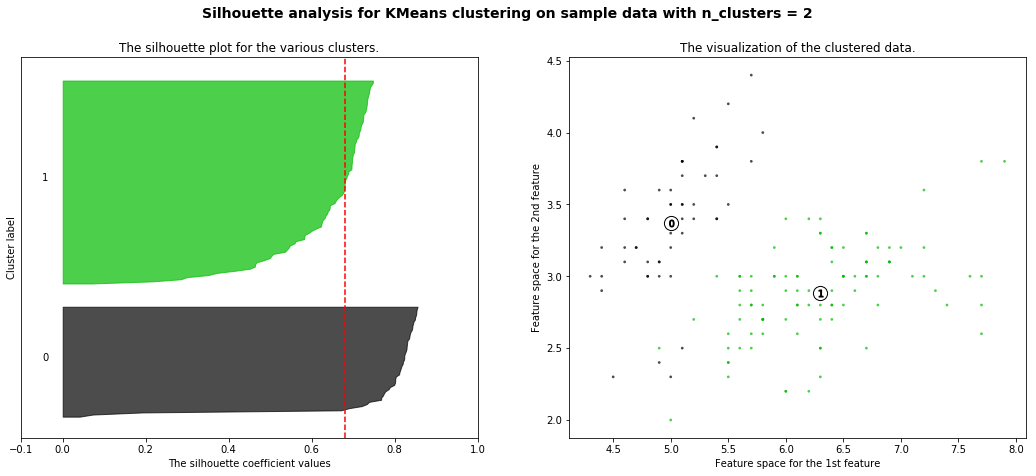

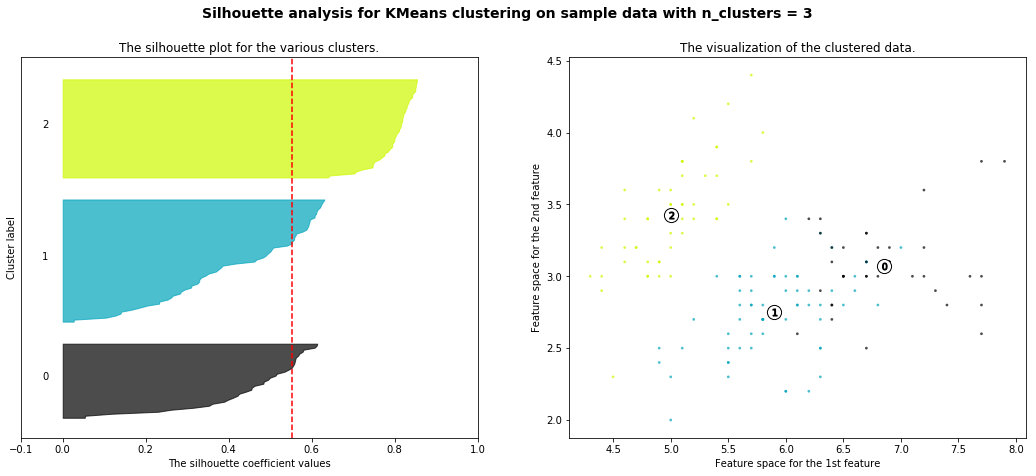

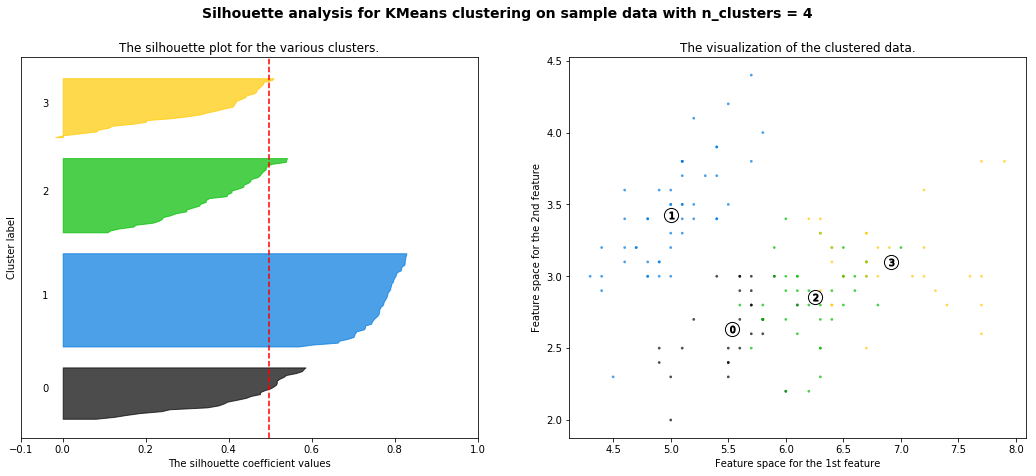

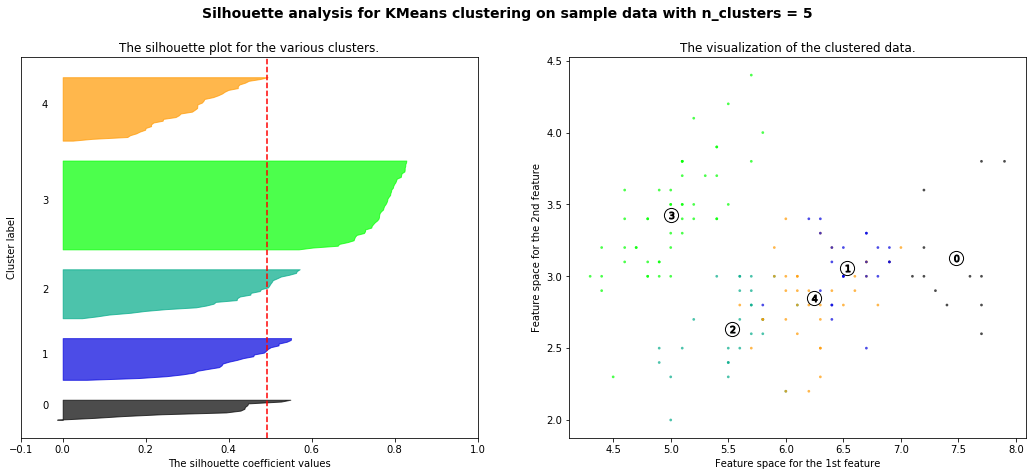

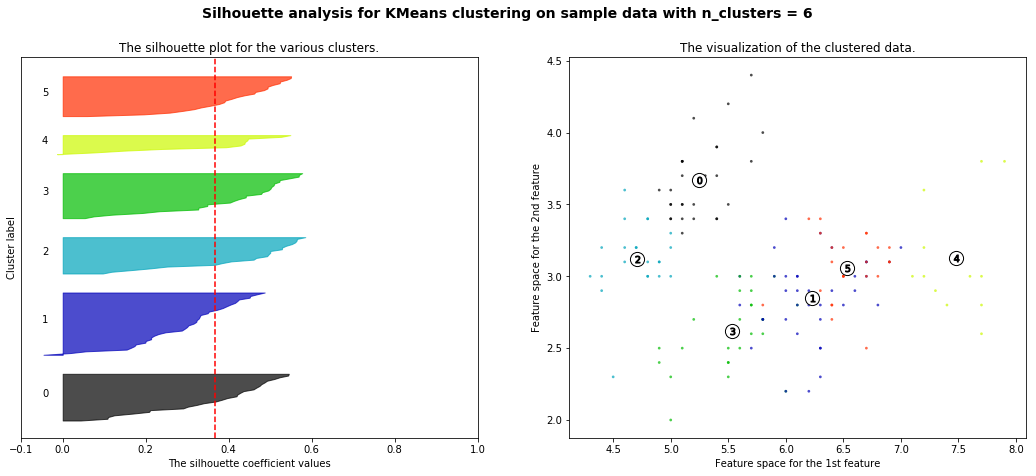

In [87]:
from __future__ import print_function

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit(X).labels_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Interestingly, these methods do not pick up that 3 is the "correct" number of clusters.

# Gaussian Mixture Models #

Let's now change the way we think about things. Instead of just saying there $K$ distinct clusters, let's assume there are $K$ different processes generating the data. Furthermore, for the sake of simplicity, let's assume the data comes from $K$ different Gaussian distributions.

Now, with our redefinition, the latent variable $\mathbf{z}$ is an indicator variable telling us which process generated the data. Therefore, the values of $z_k$ are indicator variables with $1$-of-$K$ representations that satisfy $z _ { k } \in \{ 0,1 \} \text { and } \sum _ { k } z _ { k } = 1$.

We also need some other new definitions:

$\pi _ { k }=p \left( z _ { k } = 1 \right)$ is essentially our *prior probability*. It is the probability that process $k$ generates a sample

$$
0 \leq \pi _ { k } \leq 1 \text { and } \sum _ { k = 1 } ^ { K } \pi _ { k } = 1
$$

Now we have also define the conditional probability distribution that a sample $\mathbf{v}$ came from a process $k$ as follows:

$$
p ( \mathbf { v } | \mathbf { z } ) = p ( \mathbf { v } | z _ { k } = 1 ) = p _ { k } ( \mathbf { v } )
$$

We obtain the unconditional probability for the sample $\mathbf{v}$ by marginalizing over $\mathbf{z}$:

$$
\begin{aligned} p ( \mathbf { v } ) & = \sum _ { \mathbf { z } } p ( \mathbf { v } , \mathbf { z } ) = \sum _ { \mathbf { z } } p ( \mathbf { z } ) p ( \mathbf { v } | \mathbf { z } ) \\ & = \sum _ { k = 1 } ^ { K } p \left( z _ { k } = 1 \right) p ( \mathbf { v } | z _ { k } = 1 ) = \sum _ { k = 1 } ^ { K } \pi _ { k } p _ { k } ( \mathbf { v } ) \end{aligned}
$$

Using Bayes Rule, we can then calculate the probability that a given data point was generated by a process $k$:

$$
p \left( z _ { k } = 1 | \mathbf { v } \right) = \frac { p \left( z _ { k } = 1 \right) p ( \mathbf { v } | z _ { k } = 1 ) } { p ( \mathbf { v } ) } = \pi _ { k } \frac { p _ { k } ( \mathbf { v } ) } { p ( \mathbf { v } ) }
$$

We call this quantity the *responsibility* that process $k$ takes for explaining the sample $\mathbf{v}$. Calculating the responsibility allows us assign each data point to a cluster, based on which cluster gives the highest responsibility. The nice thing here is that cluster assignements are now not absolute, but associated with probabilities. This is known as *soft clustering*

It is easy to verify for example that the responsibiilites sum to 1. 

$$
\sum _ { k = 1 } ^ { K } p \left( z _ { k } = 1 | \mathbf { v } \right) = \frac { \sum _ { k = 1 } ^ { K } \pi _ { k } p _ { k } ( \mathbf { v } ) } { p ( \mathbf { v } ) } = 1
$$

However, before we can solve for the responsibilities, we must determine $\pi _ { k }$ and $p _ { k } ( \mathbf { v } )$ for $k = 1 , \ldots , K$. To do this we attempt to maximize the joint likelihood for the data samples $\mathbf{v}_1,...,\mathbf{v}_n$:

$$
\prod _ { n = 1 } ^ { N } p \left( \mathbf { v } _ { n } \right) = \prod _ { n = 1 } ^ { N } \sum _ { k = 1 } ^ { K } \pi _ { k } p _ { k } \left( \mathbf { v } _ { n } \right)
$$

In actuality, we attempt to maximize the log likelihood as given below:

$$
\mathcal { L } = \sum _ { n = 1 } ^ { N } \log p \left( \mathbf { v } _ { n } \right) = \sum _ { n = 1 } ^ { N } \log \left( \sum _ { k = 1 } ^ { K } \pi _ { k } p _ { k } \left( \mathbf { v } _ { n } \right) \right)
$$

Using the constraint that the mixing coefficients $\pi_k$ must sum to $1$, one can use Lagrange Multipliers to arrive at the following:

$$
\pi _ { k } = \frac { 1 } { N } \sum _ { n = 1 } ^ { N } p \left( z _ { n k } = 1 | \mathbf { v } _ { n } \right)
$$

Which shows that the mixing coefficient for process $k$ is just the average responsibility of being generated by process $k$ over all of the data samples. Of course the responsibilites all depend on the mixing coefficients, so this is certainly not a closed for solution.

Finding the solution is usually an iterative scheme. First, we choose $K$ and often initialize the clusters using k-means. From there, we calculate the means $\mu_k$ and covariances $\Sigma_k$, which allow us to calculate $\pi_k$. These parameters allow for a calculation of the responsibilities, with which we can repeat the process.

Note that finding the means and variances requires maximizing the likelihood with respect to those parameters. For example, in Gaussian Mixture Models, we start with the canonical Gaussian distribution:

$$
p _ { k } ( \mathbf { v } ) = \frac { 1 } { \sqrt { \left| 2 \pi \Sigma _ { k } \right| } } \exp \left( - \frac { 1 } { 2 } \left( \mathbf { v } - \boldsymbol { \mu } _ { k } \right) ^ { T } \mathbf { \Sigma } _ { k } ^ { - 1 } \left( \mathbf { v } - \boldsymbol { \mu } _ { k } \right) \right)
$$

Maximizing the likelihood leads to:

$$
\boldsymbol { \mu } _ { k } = \frac { 1 } { N _ { k } } \sum _ { n = 1 } ^ { N } p \left( z _ { n k } = 1 | \mathbf { v } _ { n } \right) \mathbf { v } _ { n }
$$

$$
\boldsymbol { \Sigma } _ { \boldsymbol { k } } = \frac { 1 } { N _ { k } } \sum _ { n = 1 } ^ { N } p \left( z _ { n k } = 1 | \mathbf { v } _ { n } \right) \left( \mathbf { v } _ { n } - \boldsymbol { \mu } _ { k } \right) \left( \mathbf { v } _ { n } - \boldsymbol { \mu } _ { k } \right) ^ { T }
$$

where 

$$
N _ { k } = \sum _ { n = 1 } ^ { N } p \left( z _ { n k } = 1 | \mathbf { v } _ { n } \right)
$$

such that $\pi_k = \frac{N_k}{N}$ .

